In [2]:
import logging
import itertools
from prepare_data import HCDALoader
from sklearn.model_selection import KFold

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
loader = HCDALoader()

# load index values from main table
app_ix = loader.applications_train_index()

2018-06-24 18:18:23,413 - DEBUG - Reading application_train.csv...
2018-06-24 18:18:31,643 - DEBUG - Finished reading application_train.csv


In [4]:
# fit model using k-fold verification
kf = KFold(n_splits=4, shuffle=True)
for fold_indexes in kf.split(app_ix):
    print(fold_indexes[0].shape, fold_indexes[1].shape)
    
data_train, target_train, data_val, target_val = loader.load_train_val(fold_indexes[0], fold_indexes[1])

(230633,) (76878,)
(230633,) (76878,)
(230633,) (76878,)
(230634,) (76877,)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [5]:
data_train.shape, target_train.shape, data_val.shape, target_val.shape

((230634, 225), (230634,), (76877, 225), (76877,))

In [6]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
data_train_os, target_train_os = ros.fit_sample(data_train, target_train)

In [7]:
import numpy as np

np.unique(target_train_os, return_counts=True)

(array([0, 1]), array([212035, 212035]))

In [8]:
from models import LinearNN

linear_nn = LinearNN(data_train_os.shape[1], l2_reg=1e-3)
linear_nn.fit(data_train_os, target_train_os, data_val, target_val, num_epochs=5)

Using TensorFlow backend.


Train on 424070 samples, validate on 76877 samples
Epoch 1/5
424070/424070 [==============================] - 25s 59us/step - loss: 0.6788 - acc: 0.6788 - val_loss: 0.6632 - val_acc: 0.6807
Epoch 2/5
424070/424070 [==============================] - 25s 59us/step - loss: 0.6280 - acc: 0.6957 - val_loss: 0.6250 - val_acc: 0.6928
Epoch 3/5
424070/424070 [==============================] - 24s 57us/step - loss: 0.6024 - acc: 0.7040 - val_loss: 0.6183 - val_acc: 0.6929
Epoch 4/5
424070/424070 [==============================] - 24s 57us/step - loss: 0.5869 - acc: 0.7095 - val_loss: 0.6417 - val_acc: 0.6659
Epoch 5/5
424070/424070 [==============================] - 27s 63us/step - loss: 0.5773 - acc: 0.7142 - val_loss: 0.5983 - val_acc: 0.6997


In [9]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.70335876  0.29664124]
 [ 0.34179248  0.65820752]]


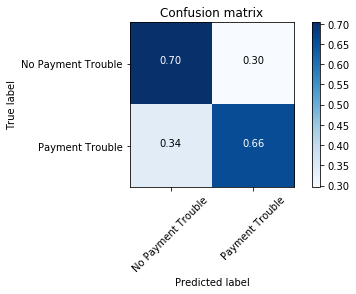

In [13]:
from sklearn.metrics import confusion_matrix

predict_val = linear_nn.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

In [12]:
np.unique(predict_val, return_counts=True), np.unique(predict_val, return_counts=True)

((array([ 0.,  1.], dtype=float32), array([51821, 25056])),
 (array([  4.58533222e-13,   5.61111380e-10,   4.66813299e-09, ...,
           9.99993324e-01,   9.99995232e-01,   9.99995947e-01], dtype=float32),
  array([1, 1, 1, ..., 1, 1, 1])))